# **0 - Imports and Kaggle setup**

## Imports

In [1]:
# in case needed

#!pip install category_encoders
#!pip install eli5
#!pip install shap
#!pip install scikit-optimize

#!pip install kaggle


In [2]:
import os

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import category_encoders as ce
from category_encoders import TargetEncoder

import zipfile

import sklearn
import imblearn
import xgboost as xgb

import sklearn.metrics as metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression, BayesianRidge, Ridge

import pymc as pm
import arviz as az

import shap
#import eli5

pd.set_option('display.max_columns', None)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
from helpers_preprocessing import (get_data,
                                   inspect_data,
                                   target_encode_dfs,
                                   split,
                                   feature_eng,
                                   minmax_scale_dfs)

from helpers_model import (regression_results,
                           freq_lr,
                           predict_br,
                           bayesian_lr,
                           bayesian_lr_t,
                           b_tree,
                           freq_tree,
                           convert_scaled,
                           compare_models,
                           plot_coef)

## Kaggle setup

These cells define the download of the dataset directly from the Kaggle API.

In [83]:
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

In [86]:
!kaggle datasets download -d nikhilbhathi/data-scientist-salary-us-glassdoor

zip_file_path = "data-scientist-salary-us-glassdoor.zip"

# Define the directory where you want to extract the contents
extract_dir = "."

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_dir)

# Optionally, you can remove the zip file after extraction
os.remove(zip_file_path)

Dataset URL: https://www.kaggle.com/datasets/nikhilbhathi/data-scientist-salary-us-glassdoor
License(s): CC0-1.0
100%|██████████████████████████████████████| 1.00M/1.00M [00:00<00:00, 2.87MB/s]
100%|██████████████████████████████████████| 1.00M/1.00M [00:00<00:00, 2.86MB/s]


Ensure that the downloading process succesfully finished.

# **1 - Load the data and perform pre-processing steps, including Encoding, Scaling and EDA**

## Getting data

In [8]:
data = get_data('data_cleaned_2021.csv')

In [9]:
data.columns

Index(['Size', 'Type of ownership', 'Sector', 'Revenue', 'Avg Salary(K)',
       'Job Location', 'Age', 'Python', 'spark', 'aws', 'excel', 'sql', 'sas',
       'keras', 'pytorch', 'scikit', 'tensor', 'hadoop', 'tableau', 'bi',
       'flink', 'mongo', 'google_an', 'job_title_sim'],
      dtype='object')

In [10]:
inspect_data(data)

          Size   Type of ownership               Sector  \
0  501 - 1000    Company - Private  Aerospace & Defense   
1      10000+   Other Organization          Health Care   
2  501 - 1000    Company - Private    Business Services   

                      Revenue  Avg Salary(K) Job Location Age  Python  spark  \
0   $50 to $100 million (USD)           72.0           NM  48       1      0   
1      $2 to $5 billion (USD)           87.5           MD  37       1      0   
2  $100 to $500 million (USD)           85.0           FL  11       1      1   

   aws  excel  sql  sas  keras  pytorch  scikit  tensor  hadoop  tableau  bi  \
0    0      1    0    1      0        0       0       0       0        1   1   
1    0      0    0    0      0        0       0       0       0        0   0   
2    0      1    1    1      0        0       0       0       0        0   0   

   flink  mongo  google_an   job_title_sim  
0      0      0          0  data scientist  
1      0      0          0  dat

### Outlier with InterQuartile Range

During our analysis in subsequent chapters of this notebook, we have noticed that the target variable is affected by severe outliers. Our approach is to identify them, and then to replace them using the `median value` of the target variable itself.

Text(0.5, 1.0, 'BoxPlot for the target variable')

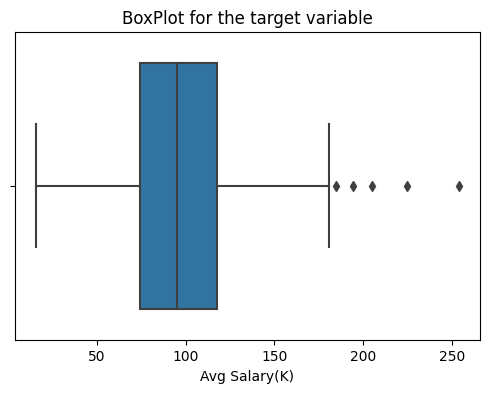

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(data = data, x='Avg Salary(K)')
plt.title('BoxPlot for the target variable')

In [12]:
Q1 = data['Avg Salary(K)'].quantile(0.25)
Q3 = data['Avg Salary(K)'].quantile(0.83)

IQR = Q3 - Q1

# Define lower and upper bounds for outliers for the 'Avg Salary(K)' column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers in the 'Avg Salary(K)' column
outliers = (data['Avg Salary(K)'] < lower_bound) | (data['Avg Salary(K)'] > upper_bound)

# Count outliers in the 'Avg Salary(K)' column
outlier_count = outliers.sum()

# Display the modified DataFrame
print("Outliers detected:", outlier_count)


data = data[(data['Avg Salary(K)'] >= lower_bound) & (data['Avg Salary(K)'] <= upper_bound)]

Outliers detected: 1


Text(0.5, 1.0, 'BoxPlot for the target variable - after the outlier deletion')

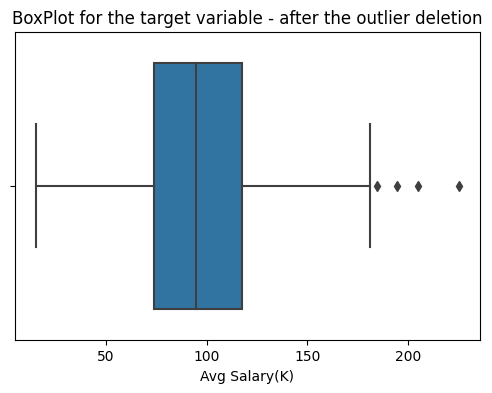

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(data = data, x='Avg Salary(K)')
plt.title('BoxPlot for the target variable - after the outlier deletion')

## Feature Engineering

In [14]:
data = feature_eng(data)
data.head()

,Type of ownership,Sector,Revenue,Avg Salary(K),Job Location,job_title_sim,Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
0,Company - Private,Aerospace & Defense,$50 to $100 million (USD),72.0,NM,data scientist,2,0,0,3,0,0
1,Other Organization,Health Care,$2 to $5 billion (USD),87.5,MD,data scientist,1,0,0,0,0,0
2,Company - Private,Business Services,$100 to $500 million (USD),85.0,FL,data scientist,2,1,0,1,0,1
3,Government,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),76.5,WA,data scientist,1,0,0,0,0,0
5,Company - Public,Real Estate,$1 to $2 billion (USD),95.0,TX,data scientist,1,2,0,2,1,0


In [15]:
trn, tst = split(data)
trn.head()

,Type of ownership,Sector,Revenue,Avg Salary(K),Job Location,job_title_sim,Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
333,Company - Public,Information Technology,$10+ billion (USD),62.5,CT,data analitics,0,0,0,1,0,0
274,Company - Public,Finance,$5 to $10 billion (USD),58.0,NJ,analyst,0,1,0,0,1,0
175,Company - Private,Insurance,$10 to $25 million (USD),98.5,NJ,data scientist,1,1,0,1,0,0
481,Company - Private,Health Care,$10 to $25 million (USD),66.0,NY,analyst,0,0,0,1,0,0
91,Company - Public,Biotech & Pharmaceuticals,$100 to $500 million (USD),174.0,CA,other scientist,0,0,0,1,0,0


## Encoding data

In [16]:
train_encoded, test_encoded, mapping = target_encode_dfs(trn, tst, ['Type of ownership', 'Sector', 'job_title_sim', 'Job Location'],'Avg Salary(K)')
train_encoded.head(1), test_encoded.head(1)

(     Type of ownership    Sector Revenue  Avg Salary(K)  Job Location  \
 333           110.7541  104.2709      10           62.5       95.4265   
 
      job_title_sim  Programming  Queries  Machine Learning  Dashboards  Cloud  \
 333        94.8772            0        0                 0           1      0   
 
      Apache  
 333       0  ,
      Type of ownership    Sector Revenue  Avg Salary(K)  Job Location  \
 555           110.7541  118.2559      10           84.5      104.2849   
 
      job_title_sim  Programming  Queries  Machine Learning  Dashboards  Cloud  \
 555         97.473            0        0                 0           0      1   
 
      Apache  
 555       0  )

In [17]:
mapping

{'Type of ownership': {'Company - Public': 110.7541,
  'Company - Private': 93.53,
  'Nonprofit Organization': 93.1622,
  'Subsidiary or Business Segment': 102.8744,
  'Government': 97.6893,
  'Hospital': 93.1554,
  'Other Organization': 91.3388,
  'School / School District': 93.9409},
 'Sector': {'Information Technology': 104.2709,
  'Finance': 97.8734,
  'Insurance': 97.9897,
  'Health Care': 91.8267,
  'Biotech & Pharmaceuticals': 118.2559,
  'Business Services': 92.1586,
  'Aerospace & Defense': 96.7166,
  'Manufacturing': 95.182,
  'Media': 99.9018,
  'Agriculture & Forestry': 96.6732,
  'Retail': 100.8929,
  'Real Estate': 100.1335,
  'Oil, Gas, Energy & Utilities': 95.7441,
  'Government': 96.7951,
  'Telecommunications': 103.6893,
  'Travel & Tourism': 94.93,
  'Arts, Entertainment & Recreation': 92.5097,
  'Transportation & Logistics': 98.6181,
  'Education': 93.6179},
 'job_title_sim': {'data analitics': 94.8772,
  'analyst': 70.9877,
  'data scientist': 109.1836,
  'other sc

In [18]:
import joblib
joblib.dump(mapping, 'Salary Prediction/mapping.pkl')  #we need it for the app


['Salary Prediction/mapping.pkl']

## Scaling data

In [19]:
train_scaled, test_scaled, scaler = minmax_scale_dfs(train_encoded, test_encoded)
train_scaled.head(1),test_scaled.head(1)

(   Type of ownership   Sector  Revenue  Avg Salary(K)  Job Location  \
 0                1.0  0.47085      1.0       0.224344       0.12415   
 
    job_title_sim  Programming  Queries  Machine Learning  Dashboards  Cloud  \
 0       0.625447          0.0      0.0               0.0    0.333333    0.0   
 
    Apache  
 0     0.0  ,
    Type of ownership  Sector  Revenue  Avg Salary(K)  Job Location  \
 0                1.0     1.0      1.0       0.329356      0.451171   
 
    job_title_sim  Programming  Queries  Machine Learning  Dashboards  Cloud  \
 0       0.693407          0.0      0.0               0.0         0.0    1.0   
 
    Apache  
 0     0.0  )

In [20]:
joblib.dump(scaler, 'Salary Prediction/scaler.pkl')  # we need it for the app

['Salary Prediction/scaler.pkl']

## Train test split

In [21]:
X_train = train_scaled.drop(columns=['Avg Salary(K)'])
y_train = train_scaled['Avg Salary(K)']

X_test = test_scaled.drop(columns=['Avg Salary(K)'])
y_test = test_scaled['Avg Salary(K)']

In [22]:
X_train.head(3)

,Type of ownership,Sector,Revenue,Job Location,job_title_sim,Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
0,1.000000,0.470850,1.0,0.124150,0.625447,0.0,0.0,0.0,0.333333,0.0,0.0
1,1.000000,0.228789,0.9,0.312354,0.000000,0.0,0.5,0.0,0.000000,1.0,0.0
2,0.112859,0.233189,0.2,0.312354,1.000000,0.5,0.5,0.0,0.333333,0.0,0.0


## Correlation Matrix and VIF

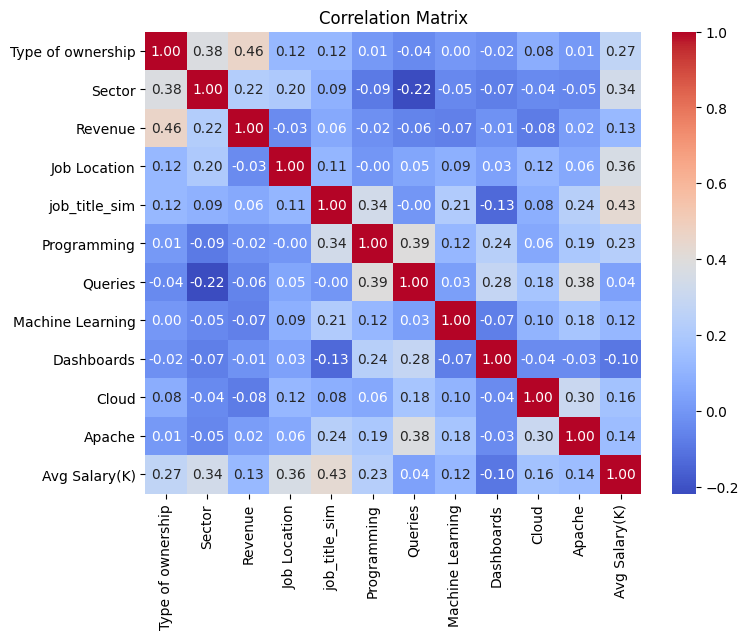

In [23]:
correlation_matrix = pd.concat([X_train, y_train], axis = 1).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

plt.show()

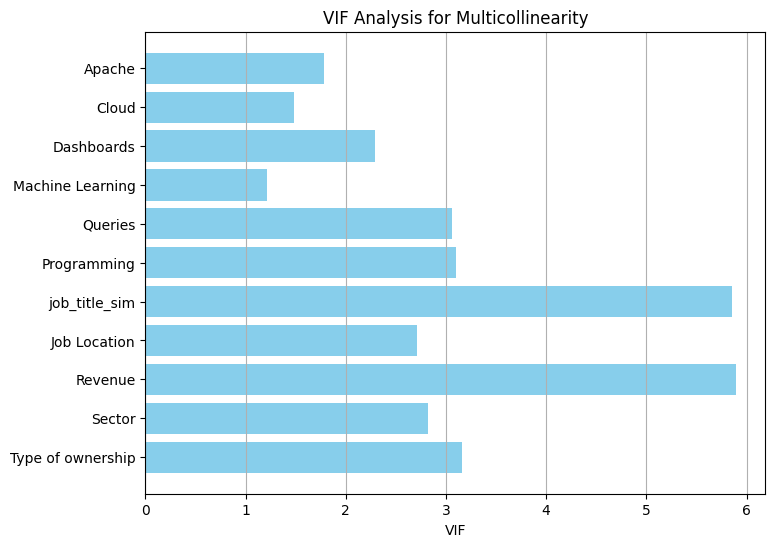

In [24]:
# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Plot VIF values
plt.figure(figsize=(8, 6))
plt.barh(vif_data["Feature"], vif_data["VIF"], color='skyblue')
plt.xlabel('VIF')
plt.title('VIF Analysis for Multicollinearity')
plt.grid(axis='x')
plt.show()

## Box plots 

### train

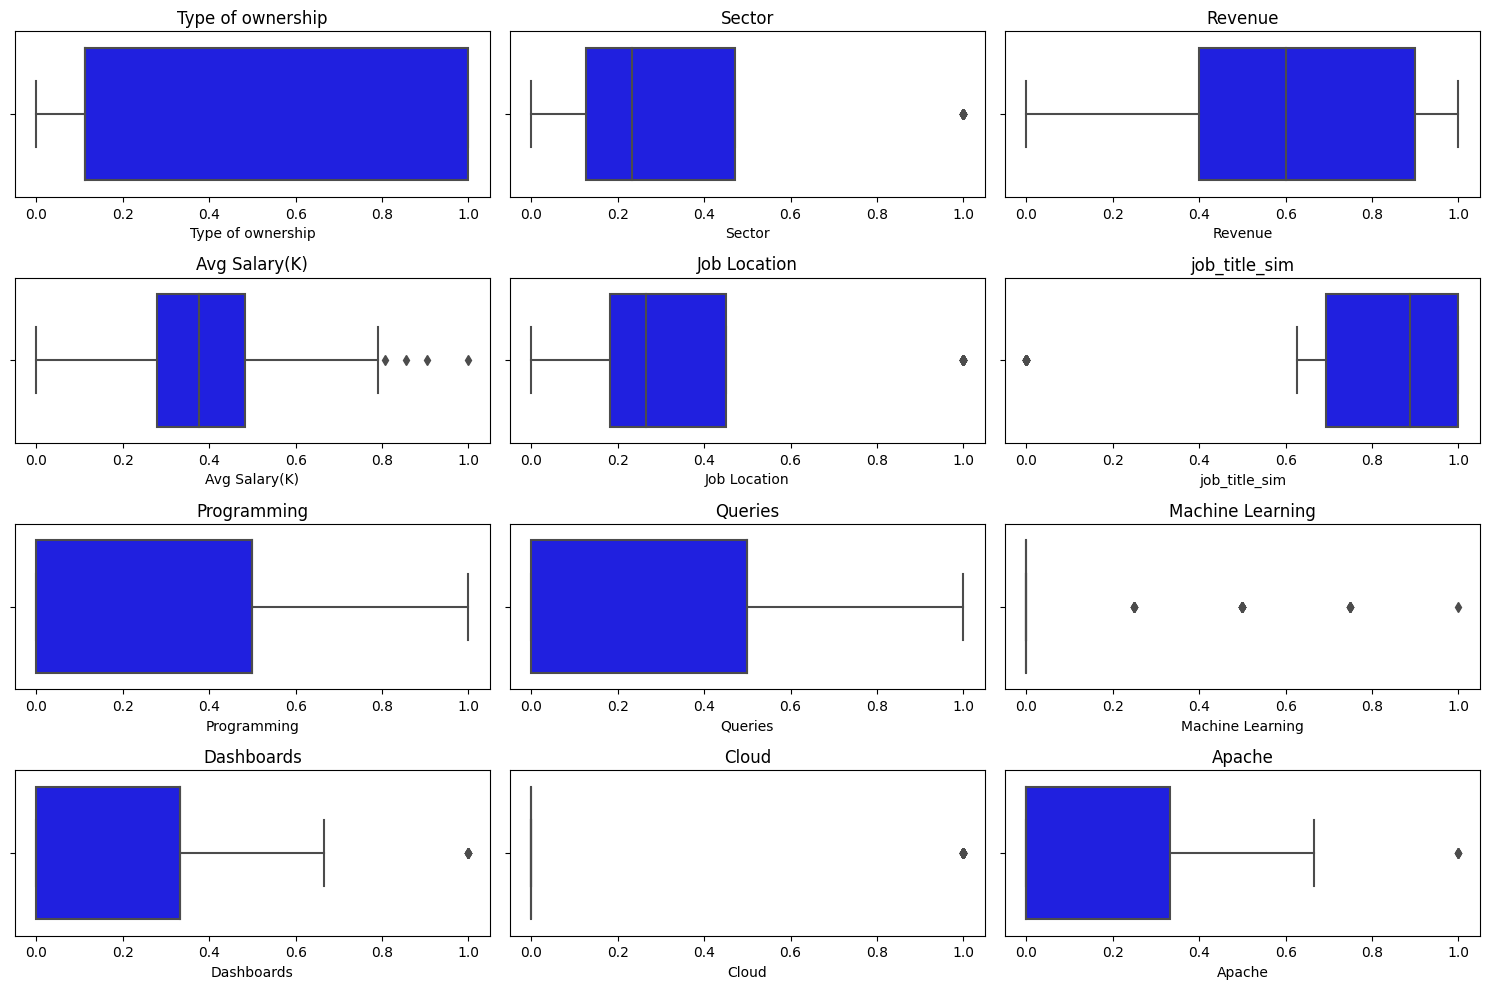

In [25]:
# Filter numerical and binary columns
numerical_columns = [col for col in train_scaled.columns if train_scaled[col].dtype in ['int64', 'float64']]
binary_columns = [col for col in train_scaled.columns if train_scaled[col].nunique() == 2]

# Define subplot layout for numerical features
num_numerical_columns = len(numerical_columns)
num_rows_numerical = (num_numerical_columns // 3) + (num_numerical_columns % 3 > 0)  # Adjust for odd number of numerical columns

# Create subplots for numerical features
fig, axes = plt.subplots(num_rows_numerical, 3, figsize=(15, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot box plots for numerical features
for i, column in enumerate(numerical_columns):
    color = 'blue'  # Default color for numerical features
    if column in binary_columns:
        color = 'red'  # Change color for binary features
    sns.boxplot(x=train_scaled[column], ax=axes[i], color=color)
    axes[i].set_title(column)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### test

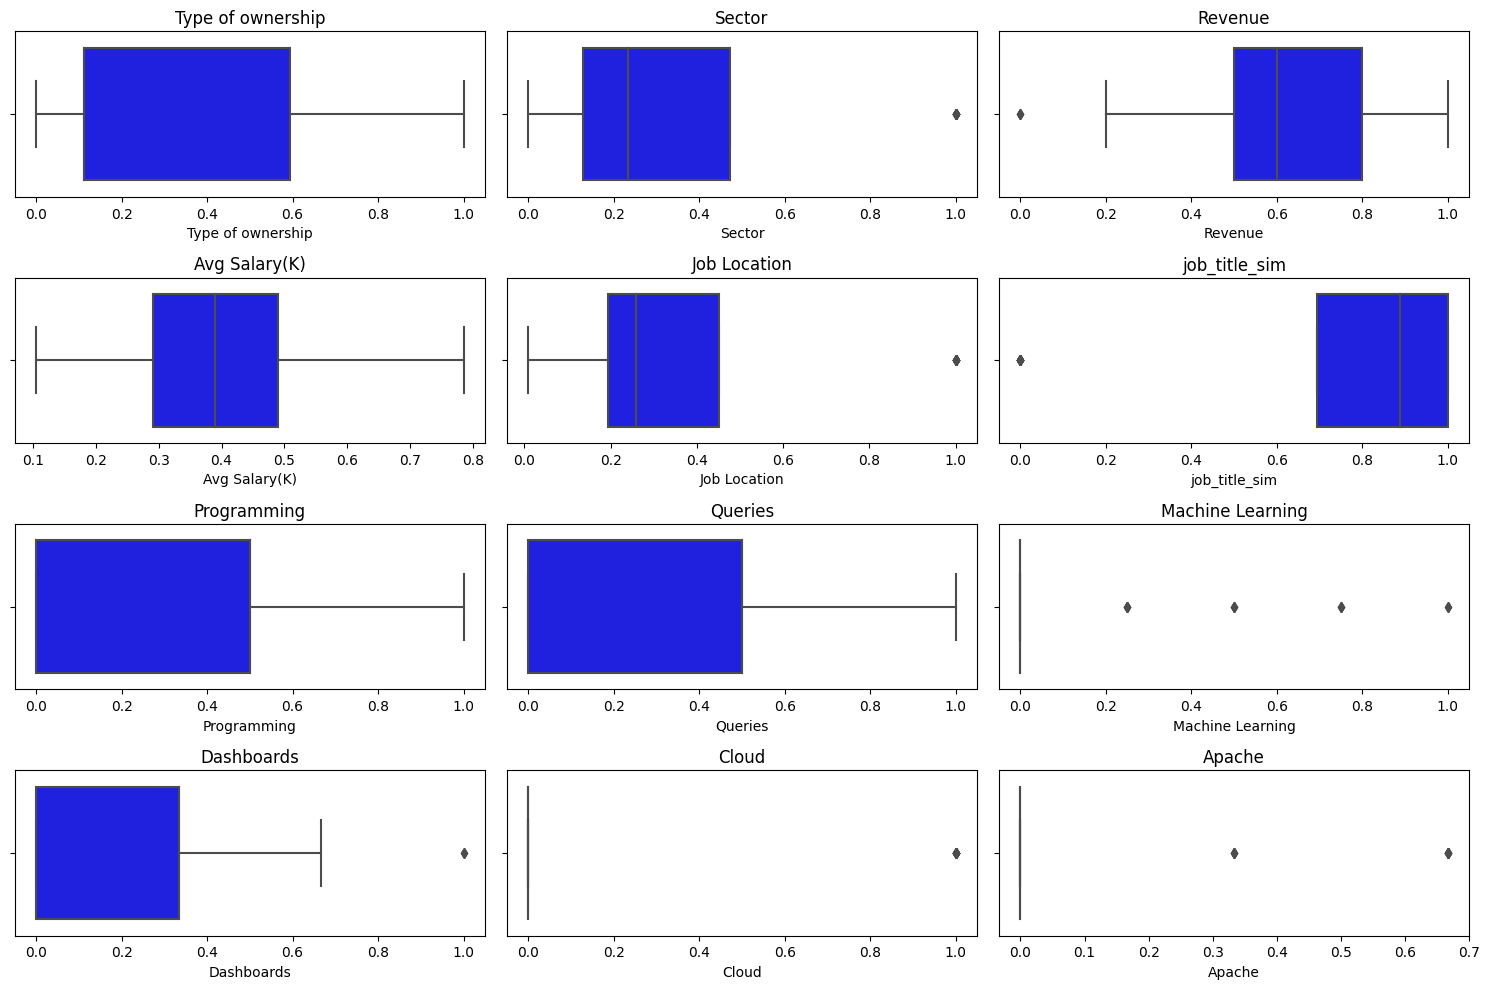

In [26]:
# Filter numerical and binary columns
numerical_columns = [col for col in test_scaled.columns if test_scaled[col].dtype in ['int64', 'float64']]
binary_columns = [col for col in test_scaled.columns if test_scaled[col].nunique() == 2]

# Define subplot layout for numerical features
num_numerical_columns = len(numerical_columns)
num_rows_numerical = (num_numerical_columns // 3) + (num_numerical_columns % 3 > 0)  # Adjust for odd number of numerical columns

# Create subplots for numerical features
fig, axes = plt.subplots(num_rows_numerical, 3, figsize=(15, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot box plots for numerical features
for i, column in enumerate(numerical_columns):
    color = 'blue'  # Default color for numerical features
    if column in binary_columns:
        color = 'red'  # Change color for binary features
    sns.boxplot(x=test_scaled[column], ax=axes[i], color=color)
    axes[i].set_title(column)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# **2 - Linear Regression, including frequentist and Bayesian approaches**

In [27]:
# Initialize an empty dictionary
models_dict = {}
predictions_dict={}

## frequentist LR

In [28]:
normal_lr, y_val_predictions_nlr = freq_lr(X_train,y_train, X_test)


models_dict['Frequentist LinReg'] = normal_lr
predictions_dict['Frequentist LinReg'] = y_val_predictions_nlr

In [29]:
regression_results(y_test, y_val_predictions_nlr)

#########
r2:  0.515
MAE:  18.7993
RMSE:  23.3024
BIC:  107.4487


In [30]:
models_dict, predictions_dict

({'Frequentist LinReg': LinearRegression()},
 {'Frequentist LinReg': array([0.5216434 , 0.27974542, 0.38012205, 0.49578371, 0.56984919,
         0.50377109, 0.23925644, 0.6263907 , 0.29193689, 0.29549182,
         0.24680924, 0.40350323, 0.47072214, 0.47514152, 0.37498159,
         0.41272644, 0.45298014, 0.3448601 , 0.44120568, 0.23084248,
         0.34318389, 0.52352302, 0.24945031, 0.32606922, 0.38272435,
         0.36541139, 0.34650758, 0.35820377, 0.1487481 , 0.13950754,
         0.50474096, 0.20104502, 0.47054289, 0.25011163, 0.40560335,
         0.39973569, 0.41387715, 0.27844102, 0.1723044 , 0.4273747 ,
         0.45913696, 0.54668027, 0.57542836, 0.42211565, 0.32544217,
         0.21538267, 0.35723709, 0.56018475, 0.38860477, 0.4209888 ,
         0.46459633, 0.33762232, 0.39005821, 0.49779469, 0.5519275 ,
         0.4690993 , 0.43494855, 0.53326441, 0.63298949, 0.34566516,
         0.46972691])})

## bayesian LR - non informative Normal priors

In [31]:
train_encoded.head(2)

,Type of ownership,Sector,Revenue,Avg Salary(K),Job Location,job_title_sim,Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
333,110.7541,104.2709,10,62.5,95.4265,94.8772,0,0,0,1,0,0
274,110.7541,97.8734,9,58.0,100.5246,70.9877,0,1,0,0,1,0


In [32]:
X_train.head()

,Type of ownership,Sector,Revenue,Job Location,job_title_sim,Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
0,1.000000,0.470850,1.0,0.124150,0.625447,0.0,0.0,0.0,0.333333,0.0,0.0
1,1.000000,0.228789,0.9,0.312354,0.000000,0.0,0.5,0.0,0.000000,1.0,0.0
2,0.112859,0.233189,0.2,0.312354,1.000000,0.5,0.5,0.0,0.333333,0.0,0.0
3,0.112859,0.000000,0.2,0.181452,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0
4,1.000000,1.000000,0.5,1.000000,0.693407,0.0,0.0,0.0,0.333333,0.0,0.0


In [33]:
trace_bayesian_lr = bayesian_lr(X_train, y_train , m = 0, s= 10, samples = 2000, tune = 1000, cores =1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [intercept, beta, sigma]


Output()

Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


<Figure size 2000x1200 with 0 Axes>

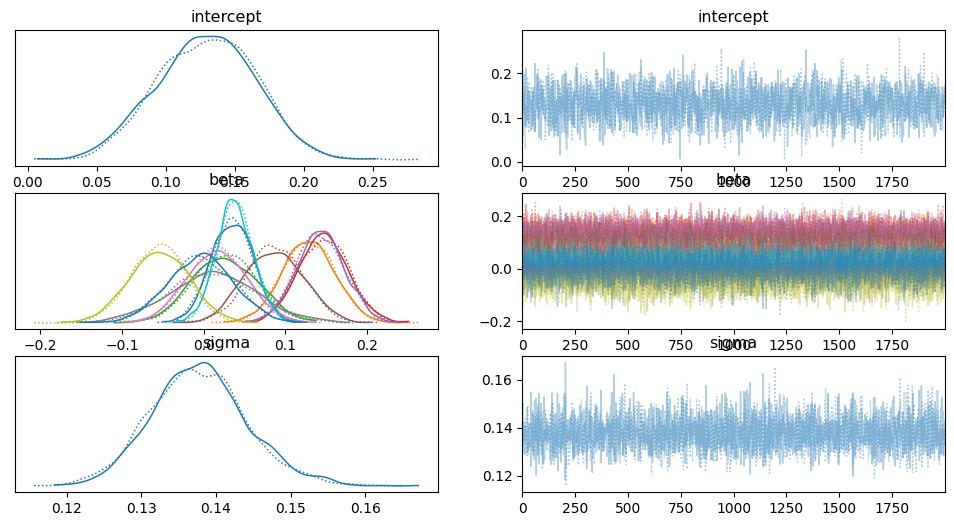

In [34]:
# Plot posterior distributions
plt.figure(figsize=(20,12))
pm.plot_trace(trace_bayesian_lr)
plt.show()

In [35]:
# Summarize posterior statistics
pm.summary(trace_bayesian_lr)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.130,0.035,0.063,0.193,0.001,0.001,1826.0,2484.0,1.0
beta[0],0.035,0.026,-0.016,0.081,0.000,0.000,3284.0,2905.0,1.0
beta[1],0.128,0.032,0.066,0.186,0.001,0.000,3783.0,3162.0,1.0
beta[2],0.026,0.039,-0.048,0.097,0.001,0.001,2708.0,2692.0,1.0
beta[3],0.147,0.031,0.090,0.206,0.000,0.000,4934.0,2715.0,1.0
beta[4],0.143,0.029,0.090,0.199,0.001,0.000,2690.0,2795.0,1.0
beta[5],0.087,0.035,0.025,0.155,0.001,0.000,3459.0,3019.0,1.0
beta[6],0.016,0.036,-0.053,0.083,0.001,0.000,3567.0,2488.0,1.0
beta[7],0.011,0.054,-0.092,0.112,0.001,0.001,4544.0,2894.0,1.0
beta[8],-0.055,0.036,-0.123,0.010,0.001,0.000,3906.0,2642.0,1.0


In [36]:
lr_model, y_val_predictions, coefficients_dict_lr = predict_br(trace_bayesian_lr, X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [37]:
models_dict['Bayesian LinReg - Normal'] = lr_model
predictions_dict['Bayesian LinReg - Normal'] = y_val_predictions

In [38]:
regression_results(y_test, y_val_predictions)

#########
r2:  0.5157
MAE:  18.7802
RMSE:  23.2857
BIC:  107.361


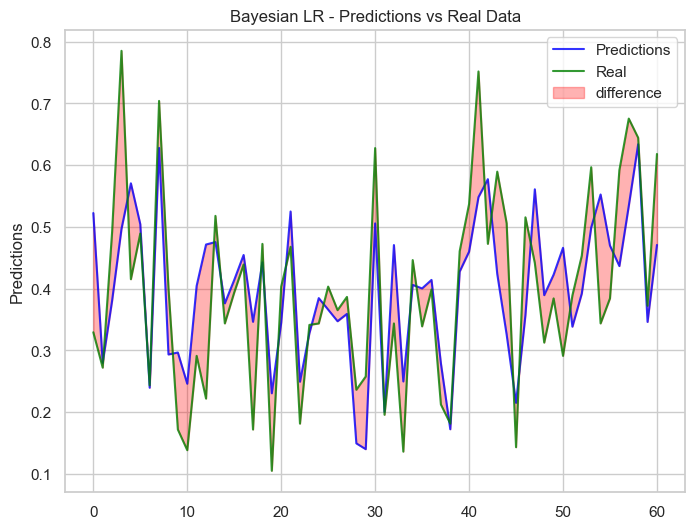

In [39]:
x_axis = np.arange(len(y_test))

plt.figure(figsize=(8,6))
sns.set_theme(style='whitegrid')
plt.plot(x_axis, y_val_predictions, color='blue', alpha=0.8, label='Predictions')
plt.plot(x_axis, y_test, color='green', alpha=0.8, label='Real')
plt.fill_between(x_axis, list(y_val_predictions.flatten()), y_test, color='red', alpha=0.3, label='difference')
plt.ylabel('Predictions')
plt.title('Bayesian LR - Predictions vs Real Data')
plt.legend()
plt.show()

## Hyper parameter tuning

Perform a Bayesian hyperparameter tuning using Gaussian Processes
([Reference](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html)).

In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Integer

# Define the objective function
def objective(params):
    m, s, samples, tune = params

    # Call your bayesian_lr function with the current set of hyperparameters
    trace_hpt = bayesian_lr(X_train, y_train, m=m, s=s, samples=samples, tune=tune)

    # Calculate the loss
    _, y_pred, _ = predict_br(trace_hpt, X_test)
    MAE = mean_absolute_error(y_test, y_pred)

    return MAE

# Define the search space for hyperparameters
space = [
    Real(0, 15, name='m'),
    Real(1, 15, name='s'),
    Integer(1000, 10000, name='samples'),
    Integer(1000, 10000, name='tune'),
#    Integer(1, 4, name='cores')
]

# Perform Bayesian optimization
res = gp_minimize(objective, space, n_calls=150, random_state=42)

# Get the best hyperparameters
best_params = res.x

Access and visualize the retrieved hyper-tuned parameters.

In [41]:
best_params = [6.691444776745618, 2.682172927057282, 2475, 6770]
best_params

[6.691444776745618, 2.682172927057282, 2475, 6770]

Deploy a Bayesian Linear Regression using the hyper-tuned parameters obtained above.

In [42]:
trace_bayesian_lr_hpt = bayesian_lr(X_train, y_train, m=best_params[0], s=best_params[1], samples=best_params[2], tune=best_params[3], cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [intercept, beta, sigma]


Output()

Output()

Sampling 2 chains for 6_770 tune and 2_475 draw iterations (13_540 + 4_950 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [43]:
lr_model_hpt, y_val_predictions_hpt, coefficients_dict_lr_hpt = predict_br(trace_bayesian_lr_hpt, X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [44]:
models_dict['Bayesian LinReg HPT'] = lr_model_hpt
predictions_dict['Bayesian LinReg HPT'] = y_val_predictions_hpt

In [45]:
regression_results(y_test, y_val_predictions_hpt)

#########
r2:  0.5155
MAE:  18.7822
RMSE:  23.2892
BIC:  107.3794


## Bayesian Linear Regression - Student-T Priors

The variables will have a suffix "_t" which distinguish them from the previus B-LR which used Normal priors.

In [46]:
trace_t = bayesian_lr_t(X_train, y_train, n=1, m=0, s=10, samples=2000, tune=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [intercept, beta, sigma]


Output()

Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

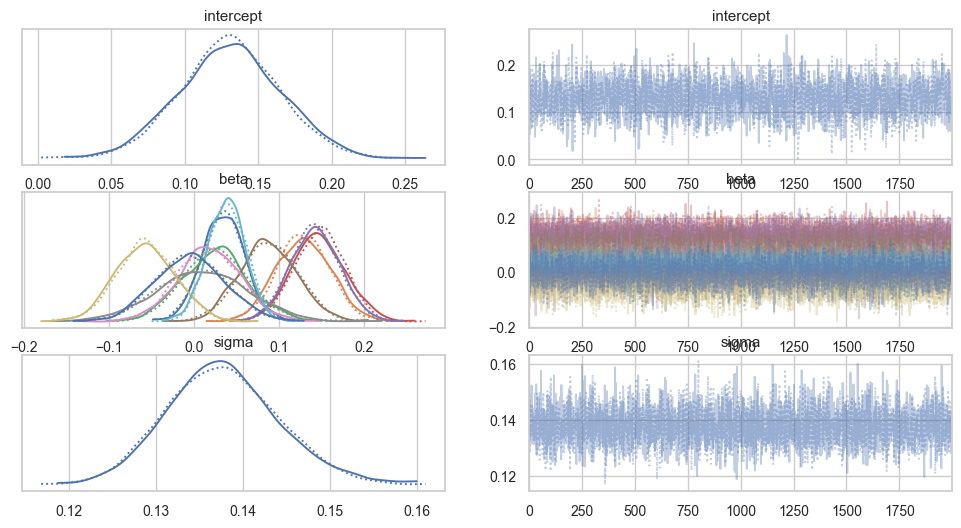

In [47]:
# Plot posterior distributions
pm.plot_trace(trace_t)

In [48]:
# Summarize posterior statistics
pm.summary(trace_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.131,0.034,0.065,0.194,0.001,0.000,2662.0,2810.0,1.0
beta[0],0.034,0.025,-0.016,0.079,0.000,0.000,3559.0,3022.0,1.0
beta[1],0.128,0.032,0.069,0.188,0.001,0.000,3143.0,2680.0,1.0
beta[2],0.025,0.038,-0.046,0.100,0.001,0.001,3079.0,3046.0,1.0
beta[3],0.147,0.030,0.088,0.203,0.000,0.000,3720.0,2580.0,1.0
beta[4],0.142,0.029,0.091,0.198,0.000,0.000,3847.0,3025.0,1.0
beta[5],0.088,0.034,0.024,0.150,0.001,0.000,3957.0,2878.0,1.0
beta[6],0.018,0.037,-0.054,0.086,0.001,0.000,2997.0,3042.0,1.0
beta[7],0.010,0.053,-0.084,0.112,0.001,0.001,4769.0,2584.0,1.0
beta[8],-0.057,0.035,-0.116,0.012,0.001,0.000,3921.0,2546.0,1.0


In [49]:
lr_model_t, y_val_predictions_t, coefficients_dict_t = predict_br(trace_t, X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [50]:
scaler.feature_names_in_[3]

'Avg Salary(K)'

In [51]:
models_dict['Bayesian LinReg - StudT'] = lr_model_t
predictions_dict['Bayesian LinReg - StudT'] = y_val_predictions_t

In [52]:
regression_results(y_test, y_val_predictions_t)

#########
r2:  0.516
MAE:  18.7853
RMSE:  23.2782
BIC:  107.3216


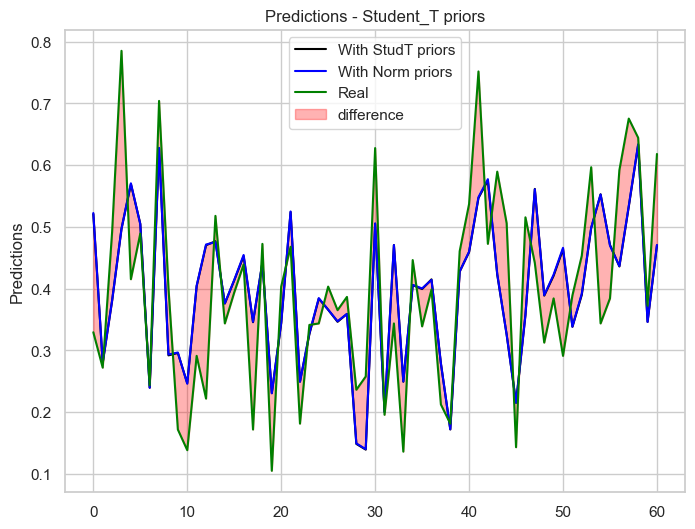

In [53]:
x_axis = np.arange(len(y_test))
plt.figure(figsize=(8,6))
sns.set_theme(style='whitegrid')

plt.plot(x_axis, y_val_predictions_t, color='black', label='With StudT priors')
plt.plot(x_axis, y_val_predictions, color='blue', label='With Norm priors')
plt.plot(x_axis, y_test, color='green', label='Real')
plt.fill_between(x_axis, list(y_val_predictions.flatten()), y_test, color='red', alpha=0.3, label='difference')
plt.ylabel('Predictions')
plt.title('Predictions - Student_T priors')
plt.legend()
plt.show()

# **3 - Ridge Regression, inclduing frequentis Ridge and Bayesian Ridge**

## Frequentist Ridge

In [54]:
ridge = Ridge(alpha=0.8)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)


regression_results(y_test, y_pred_ridge)

#########
r2:  0.515
MAE:  18.7653
RMSE:  23.3009
BIC:  107.4407


In [55]:
models_dict['Frequentist Ridge'] = ridge
predictions_dict['Frequentist Ridge']= y_pred_ridge

## Bayesian Ridge

In [56]:
# Create and fit the Bayesian Linear Regression model
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)

# Predict on the test set
y_pred_bayesian_ridge = bayesian_ridge.predict(X_test)

# Evaluate the model
regression_results(y_test, y_pred_bayesian_ridge)

#########
r2:  0.5126
MAE:  18.7683
RMSE:  23.36
BIC:  107.7497


In [57]:
models_dict['Bayesian_Ridge'] = bayesian_ridge
predictions_dict['Bayesian Ridge'] = y_pred_bayesian_ridge

# **4 - Regression Tree, including frequentist and Bayesian Tree**

## Bayesian Tree

-----------------
0000000000000000000000000 tree model 0000000000000000000000000000
x4=0.6663830411117424
 ├ <0.6663830411117424: y=0.25522993368285146, n=47
 └ ≥0.6663830411117424: x3=0.2858181791333494
    ├ <0.2858181791333494: x4=0.7144313918509577
    │ ├ <0.7144313918509577: x0=0.7970749872523215
    │ │ ├ <0.7970749872523215: y=0.2859168981572049, n=18
    │ │ └ ≥0.7970749872523215: y=0.38555156696271375, n=3
    │ └ ≥0.7144313918509577: x5=0.75
    │    ├ <0.75: y=0.4155628823712319, n=75
    │    └ ≥0.75: y=0.3517871169872422, n=12
    └ ≥0.2858181791333494: x1=0.328670561348811
       ├ <0.328670561348811: y=0.41767026781172967, n=47
       └ ≥0.328670561348811: y=0.5749117181678143, n=42
-----------------
0000000000000000000000000 info 0000000000000000000000000000
Tree depth and number of leaves: 4, 7
Feature importance: [0.011811114285698258, 0.008273841467041802, 0.0, 0.33799529088917846, 0.6417012682525569, 0.00021848510552443162, 0.0, 0.0, 0.0, 0.0, 0.0]
Train MAE: 21.30

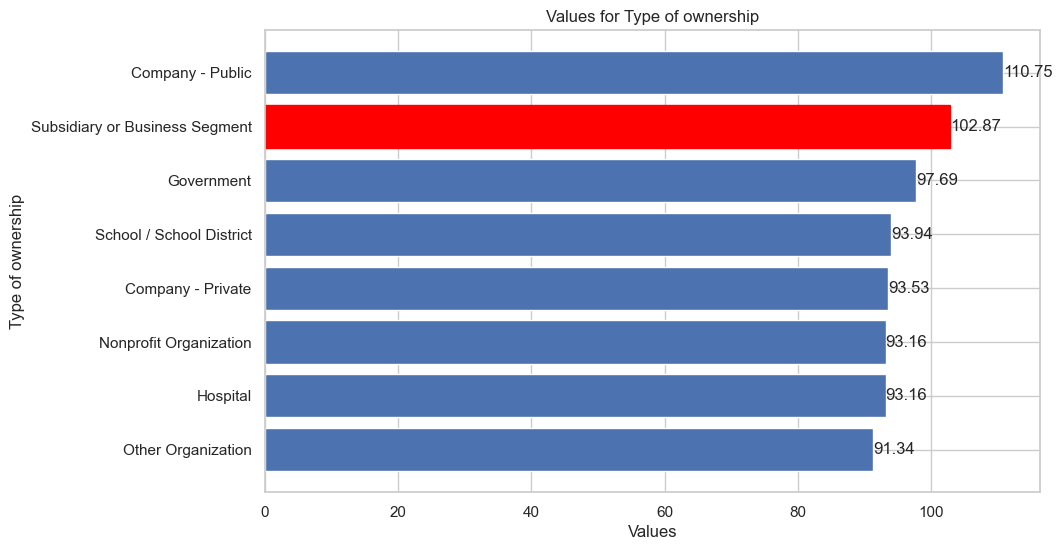

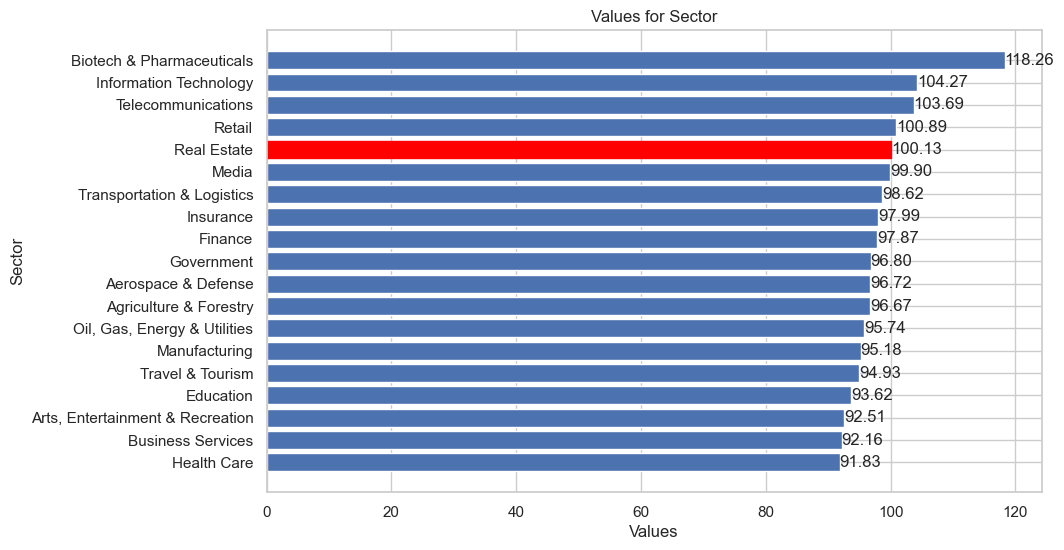

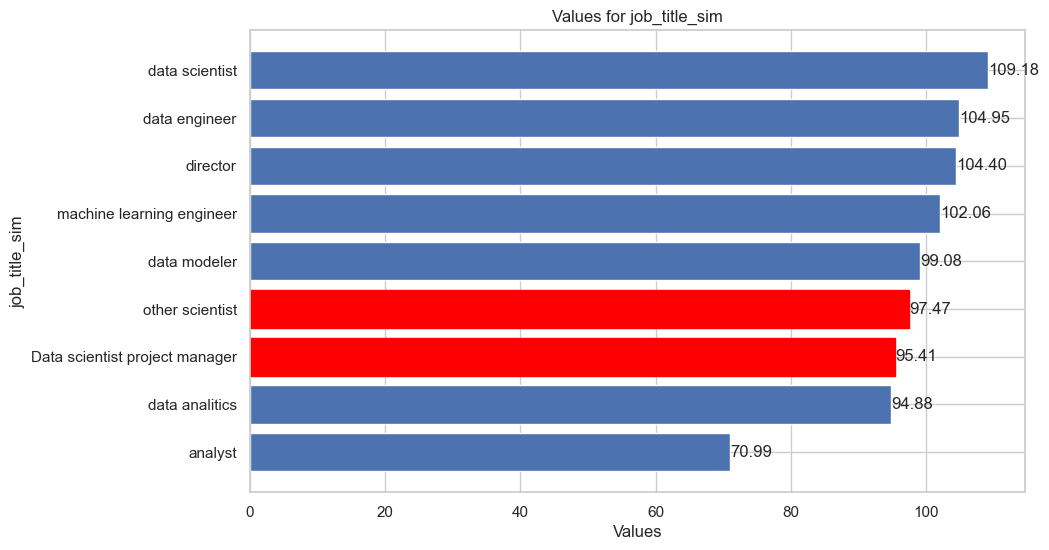

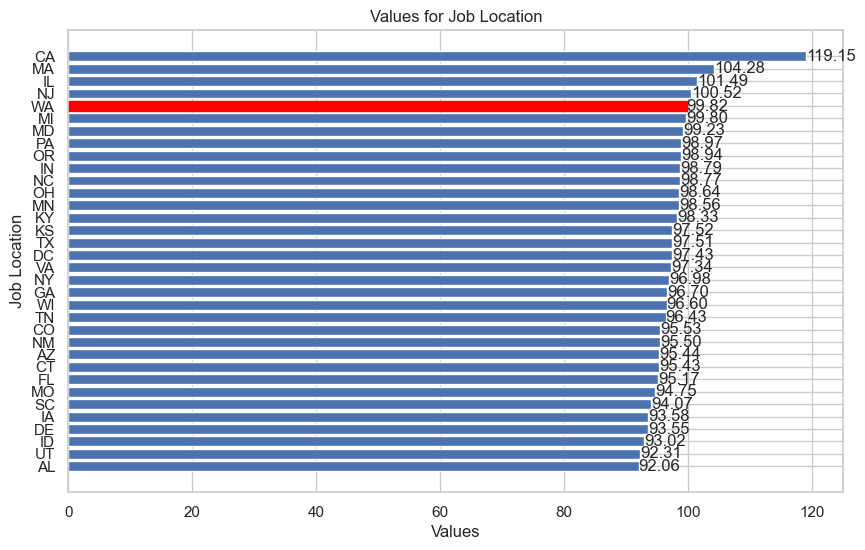

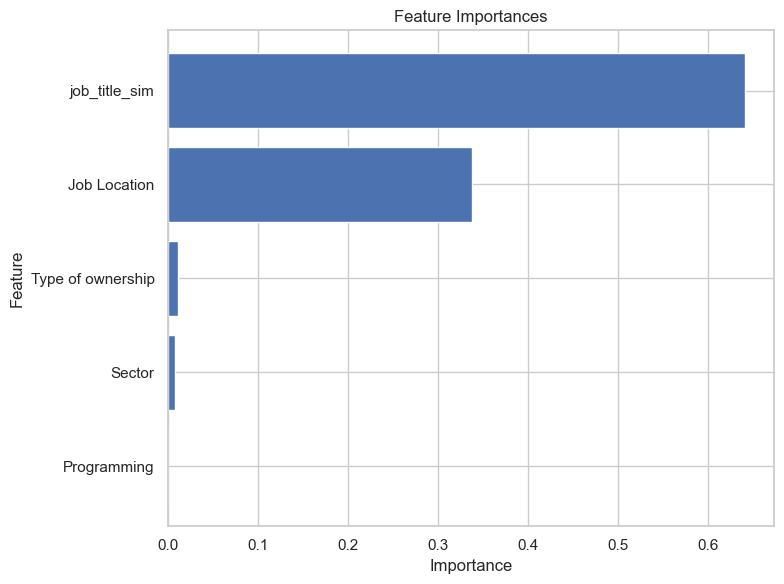

In [58]:
bayesian_tree, y_pred_bayes_tree = b_tree(X_train, y_train, X_test, y_test, scaler, mapping)

In [59]:
regression_results(y_test, y_pred_bayes_tree)

#########
r2:  0.1857
MAE:  23.1483
RMSE:  30.1943
BIC:  139.0584


we know that it is a regression but we still showed the real values based on the numerical values to be able to interpret a little, with the help of the plots above

In [60]:
models_dict['Bayesian Tree'] = bayesian_tree
predictions_dict['Bayesian Tree'] = y_pred_bayes_tree

## Frequentist Bayesian Tree

MAE of the frequentist tree: 20.820223682460195
|--- feature_4 <= 0.67
|   |--- feature_3 <= 0.17
|   |   |--- feature_8 <= 0.50
|   |   |   |--- value: [0.22]
|   |   |--- feature_8 >  0.50
|   |   |   |--- value: [0.15]
|   |--- feature_3 >  0.17
|   |   |--- feature_1 <= 0.74
|   |   |   |--- value: [0.24]
|   |   |--- feature_1 >  0.74
|   |   |   |--- value: [0.39]
|--- feature_4 >  0.67
|   |--- feature_3 <= 0.73
|   |   |--- feature_3 <= 0.13
|   |   |   |--- value: [0.27]
|   |   |--- feature_3 >  0.13
|   |   |   |--- value: [0.40]
|   |--- feature_3 >  0.73
|   |   |--- feature_1 <= 0.32
|   |   |   |--- value: [0.42]
|   |   |--- feature_1 >  0.32
|   |   |   |--- value: [0.65]



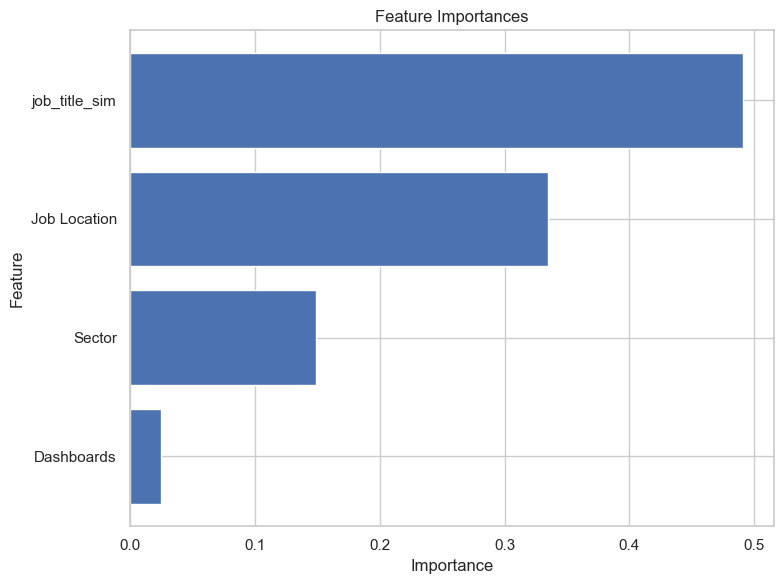

In [61]:
frequentist_tree, y_freq_tree_predictions = freq_tree(X_train, y_train, X_test, y_test)

In [62]:
regression_results(y_test, y_freq_tree_predictions)

#########
r2:  0.2583
MAE:  20.8202
RMSE:  28.8156
BIC:  133.3566


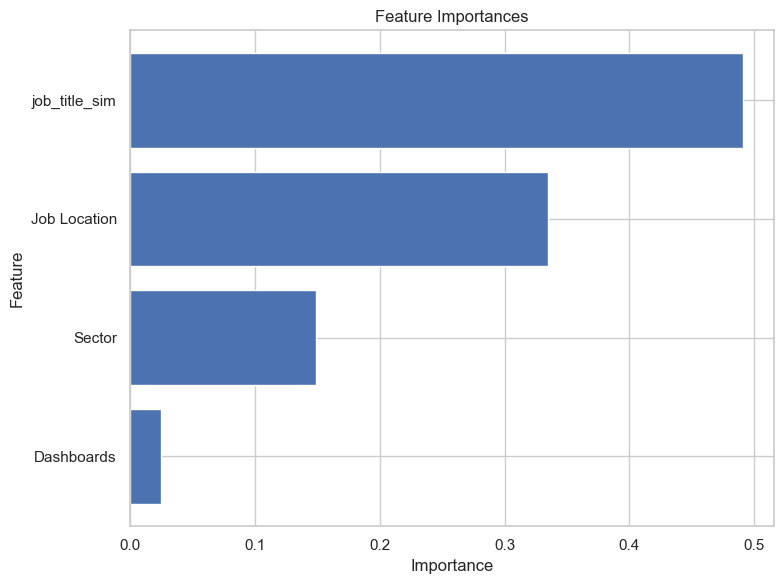

In [63]:
import matplotlib.pyplot as plt

# Retrieve feature names and importances
feature_names = frequentist_tree.feature_names_in_
importances = frequentist_tree.feature_importances_

# Filter out zero importances
non_zero_indices = importances.nonzero()[0]
filtered_feature_names = feature_names[non_zero_indices]
filtered_importances = importances[non_zero_indices]

# Sort filtered feature importances in descending order
sorted_indices = filtered_importances.argsort()

# Plot
plt.figure(figsize=(8, 6))
plt.title("Feature Importances")
plt.barh(range(len(filtered_feature_names)), filtered_importances[sorted_indices], align="center")
plt.yticks(range(len(filtered_feature_names)), filtered_feature_names[sorted_indices])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [64]:
models_dict['Frequentist Tree'] = frequentist_tree
predictions_dict['Frequentist Tree'] = y_freq_tree_predictions

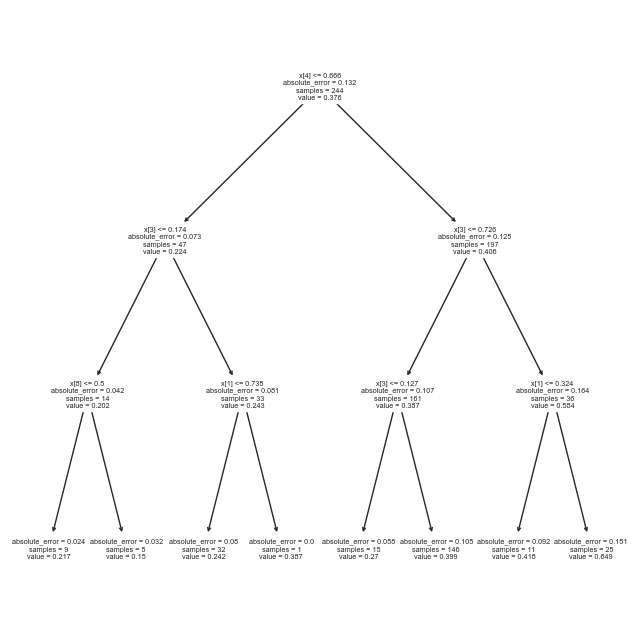

In [65]:
from sklearn.tree import plot_tree
plt.figure(figsize=(8,8))
plot_tree(frequentist_tree)
plt.show()

In [66]:
models_dict.keys(), predictions_dict.keys()

(dict_keys(['Frequentist LinReg', 'Bayesian LinReg - Normal', 'Bayesian LinReg HPT', 'Bayesian LinReg - StudT', 'Frequentist Ridge', 'Bayesian_Ridge', 'Bayesian Tree', 'Frequentist Tree']),
 dict_keys(['Frequentist LinReg', 'Bayesian LinReg - Normal', 'Bayesian LinReg HPT', 'Bayesian LinReg - StudT', 'Frequentist Ridge', 'Bayesian Ridge', 'Bayesian Tree', 'Frequentist Tree']))

# **5 - Overall Comparison**

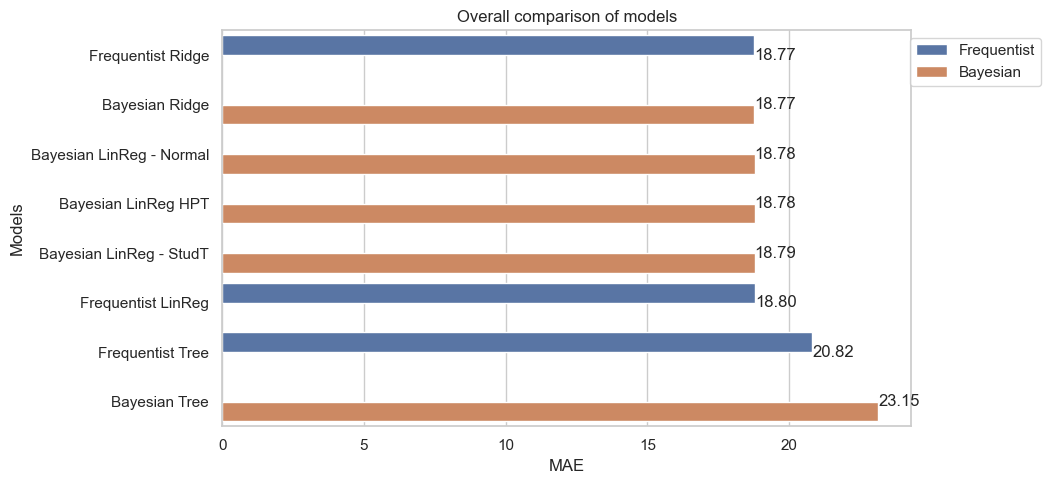

,MAE,Model_Type
Models,,
Frequentist Ridge,18.765343,Frequentist
Bayesian Ridge,18.768343,Bayesian
Bayesian LinReg - Normal,18.780234,Bayesian
Bayesian LinReg HPT,18.782178,Bayesian
Bayesian LinReg - StudT,18.785345,Bayesian
Frequentist LinReg,18.799255,Frequentist
Frequentist Tree,20.820224,Frequentist
Bayesian Tree,23.148344,Bayesian


In [67]:
results_df = compare_models(predictions_dict, y_test)
results_df

We take the best bayesian model that we have which is the bayesian ridge

In [68]:
# Save the model to a file
joblib.dump(bayesian_ridge, 'Salary Prediction/bayesian_ridge_model.pkl') # we need the best bayesian model for the app

['Salary Prediction/bayesian_ridge_model.pkl']

# **6 - Feature Importance using SHAP and ELI5** (just experimenting)

## Simple bar plot

Recall that we already have the coefficients of this model stored in `coefficients_dict`.

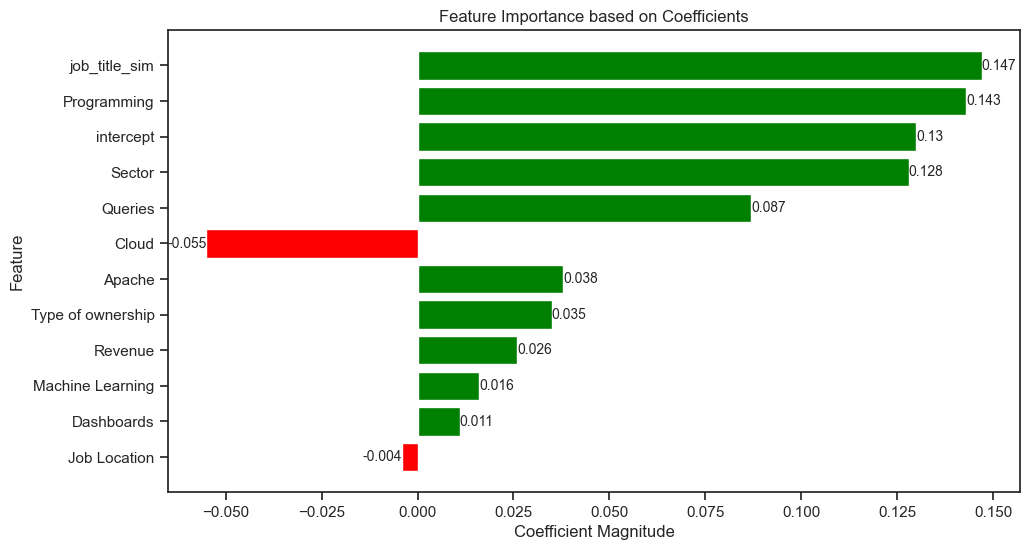

In [69]:
coefficients_dict = dict(zip(pm.summary(trace_bayesian_lr)['mean'][:12].index,
                        pm.summary(trace_bayesian_lr)['mean'][:12].values))
plot_coef(coefficients_dict)

## SHAP values - using Bayesian Ridge because Bayesian LR creates problems

Reference: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [70]:
train_scaled.columns

Index(['Type of ownership', 'Sector', 'Revenue', 'Avg Salary(K)',
       'Job Location', 'job_title_sim', 'Programming', 'Queries',
       'Machine Learning', 'Dashboards', 'Cloud', 'Apache'],
      dtype='object')

In [71]:
exp = pd.DataFrame(scaler.inverse_transform(train_scaled))

exp.columns = train_scaled.columns

exp.drop('Avg Salary(K)', axis=1, inplace=True)

exp.head(3)

,Type of ownership,Sector,Revenue,Job Location,job_title_sim,Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
0,110.7541,104.2709,10.0,95.4265,94.8772,0.0,0.0,0.0,1.0,0.0,0.0
1,110.7541,97.8734,9.0,100.5246,70.9877,0.0,1.0,0.0,0.0,1.0,0.0
2,93.5300,97.9897,2.0,100.5246,109.1836,1.0,1.0,0.0,1.0,0.0,0.0


In [72]:
train_encoded.loc[train_encoded['Avg Salary(K)'].max()]
# train_encoded.loc[train_encoded['Avg Salary(K)'].idxmax()]

Type of ownership       93.53
Sector               104.2709
Revenue                     4
Avg Salary(K)            49.0
Job Location           93.015
job_title_sim         70.9877
Programming                 1
Queries                     1
Machine Learning            0
Dashboards                  2
Cloud                       0
Apache                      0
Name: 225, dtype: object

In [73]:
explainer = shap.explainers.Linear(normal_lr, exp)
shap_values = explainer(exp)

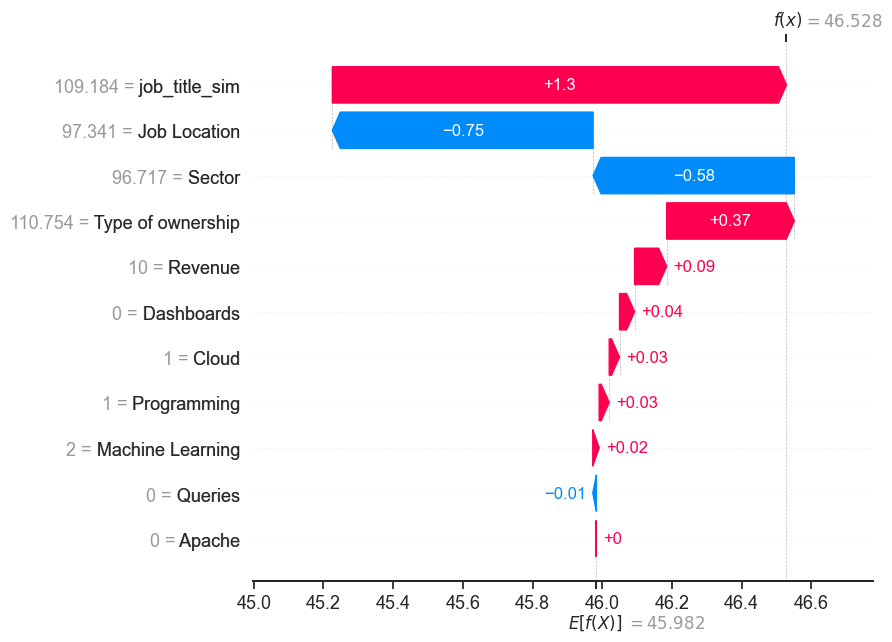

In [74]:
shap.plots.waterfall(shap_values[176], max_display=14)

***

## ELI5

Source:
- https://medium.com/@salonipriyani/explaining-ml-with-eli5-a-guide-for-numerical-computer-vision-and-natural-language-data-e29f18615311#:~:text=ELI5%20can%20be%20used%20to%20explain%20models%20such%20as%20linear,feature%20in%20the%20prediction%20process,
- https://eli5.readthedocs.io/en/latest/autodocs/lime.html?highlight=show_weights#eli5.lime.lime.TextExplainer.show_weights

In [ ]:
eli5.show_weights(models_dict['Bayesian LinReg - Normal'])